In [54]:
import pandas as pd
import glob
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

path = r'../data/curated/merged_dataset/' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in sorted(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

merged_df = pd.concat(li, axis=0, ignore_index=True)
merged_df.drop(['address', 'latitude', 'longitude', 'postcode', 'sa2_2016'], axis=1, inplace=True)
print(merged_df.columns)
merged_df


Index(['year', 'sa2_2021', 'residence_type', 'nbed', 'nbath', 'ncar',
       'min_distance_to_cbd', 'min_distance_to_park', 'min_distance_to_prim',
       'min_distance_to_second', 'min_distance_to_train',
       'min_distance_to_hosp', 'min_distance_to_poli', 'min_distance_to_shop',
       'weekly_rent', 'gdp(USD Millioins)', 'saving_rate(% of GDP)',
       'income_per_person', 'population_density', 'crime_cases'],
      dtype='object')


,year,sa2_2021,residence_type,nbed,nbath,ncar,min_distance_to_cbd,min_distance_to_park,min_distance_to_prim,min_distance_to_second,min_distance_to_train,min_distance_to_hosp,min_distance_to_poli,min_distance_to_shop,weekly_rent,gdp(USD Millioins),saving_rate(% of GDP),income_per_person,population_density,crime_cases
0,2013,204011057,House,2.0,1.0,0,227.97163,23.16035,7.35747,16.96507,35.56825,21.35025,22.04660,9.35209,300.0,1536454,6.861393,39683.563449,2.172408,86.0
1,2013,205051101,House,2.0,1.0,0,223.66084,5.71742,6.50536,6.76794,7.54355,7.42972,6.28177,9.35209,215.0,1536454,6.861393,47222.702327,5.425503,36.0
2,2013,204011057,House,2.0,1.0,0,243.25680,5.11222,0.20027,36.72106,50.85341,36.63541,0.08478,9.35209,175.0,1536454,6.861393,39683.563449,2.172408,86.0
3,2013,202011022,House,4.0,2.0,0,140.35827,78.32509,10.66523,11.91899,11.26906,177.44731,84.47341,9.35209,350.0,1536454,6.861393,43556.283562,473.765281,1288.0
4,2013,208041195,Apartment,1.0,1.0,0,13.86135,0.93250,1.32931,3.49174,2.20800,177.44731,84.47341,3.96501,275.0,1536454,6.861393,86103.411528,2834.210526,1923.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172030,2022,205021086,House,3.0,1.0,1,293.28053,0.56012,1.21809,114.77016,90.08591,140.56888,74.35608,13.64920,265.0,3305754,12.839000,54365.266130,402.000000,281.0
172031,2022,217041479,House,3.0,2.0,2,258.29111,3.49087,5.08707,3.60570,8.37185,2.60312,74.35608,13.64920,500.0,3305754,12.839000,60828.473189,689.000000,3049.0
172032,2022,208021177,House,2.0,2.0,1,9.47077,2.45011,1.33931,1.62322,3.63291,140.56888,74.35608,1.97636,750.0,3305754,12.839000,98756.492866,3656.000000,759.0
172033,2022,206041506,Apartment,1.0,1.0,1,1.84933,0.65199,1.10438,1.27940,1.87840,140.56888,74.35608,13.64920,409.0,3305754,12.839000,71305.473808,5791.000000,1788.0


In [55]:
for col in merged_df.columns:
    if col not in ['residence_type', 'year']:
        merged_df[col] = merged_df[col].astype(float)
merged_df['year'] = merged_df['year'].astype(int)
#pd.get_dummies(merged_df['sa2_2021'])
merged_df.rename({'gdp(USD Millioins)': 'gdp', 'saving_rate(% of GDP)': 'saving_rate'}, axis=1, inplace=True)
merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes
merged_df.dropna(inplace=True)

y = np.log(merged_df['weekly_rent'])
merged_df.drop('weekly_rent', axis=1, inplace=True)
X = merged_df

print(X)
print(X.dtypes)


        year     sa2_2021  residence_type  nbed  nbath  ncar  \
0       2013  204011057.0               1   2.0    1.0   0.0   
1       2013  205051101.0               1   2.0    1.0   0.0   
2       2013  204011057.0               1   2.0    1.0   0.0   
3       2013  202011022.0               1   4.0    2.0   0.0   
4       2013  208041195.0               0   1.0    1.0   0.0   
...      ...          ...             ...   ...    ...   ...   
172030  2022  205021086.0               1   3.0    1.0   1.0   
172031  2022  217041479.0               1   3.0    2.0   2.0   
172032  2022  208021177.0               1   2.0    2.0   1.0   
172033  2022  206041506.0               0   1.0    1.0   1.0   
172034  2022  206071139.0               0   1.0    1.0   1.0   

        min_distance_to_cbd  min_distance_to_park  min_distance_to_prim  \
0                 227.97163              23.16035               7.35747   
1                 223.66084               5.71742               6.50536   
2     

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state= None, shuffle= False)
sel = RandomForestRegressor(n_estimators = 100)
sel.fit(X_train, y_train)

# Get the names of features selected
sel.feature_importances_

array([0.01279589, 0.03159989, 0.00578616, 0.0850325 , 0.14366775,
       0.01872445, 0.14676737, 0.04038939, 0.04598142, 0.03254144,
       0.02964293, 0.01706158, 0.02611005, 0.00957857, 0.01297739,
       0.0085065 , 0.26523252, 0.04076896, 0.02683524])

{'year': 0.012795891237627236, 'sa2_2021': 0.03159989475146413, 'residence_type': 0.005786157078491551, 'nbed': 0.08503250465884428, 'nbath': 0.14366774557600928, 'ncar': 0.018724450729152124, 'min_distance_to_cbd': 0.14676737327409936, 'min_distance_to_park': 0.04038939378620522, 'min_distance_to_prim': 0.04598141722954516, 'min_distance_to_second': 0.032541436841652324, 'min_distance_to_train': 0.029642929375784128, 'min_distance_to_hosp': 0.017061576908210398, 'min_distance_to_poli': 0.0261100532214025, 'min_distance_to_shop': 0.009578573215184788, 'gdp': 0.012977390390923035, 'saving_rate': 0.008506499318698268, 'income_per_person': 0.26523251846460266, 'population_density': 0.040768956961254266, 'crime_cases': 0.026835236980849136}
[('residence_type', 0.005786157078491551), ('saving_rate', 0.008506499318698268), ('min_distance_to_shop', 0.009578573215184788), ('year', 0.012795891237627236), ('gdp', 0.012977390390923035), ('min_distance_to_hosp', 0.017061576908210398), ('ncar', 0.0

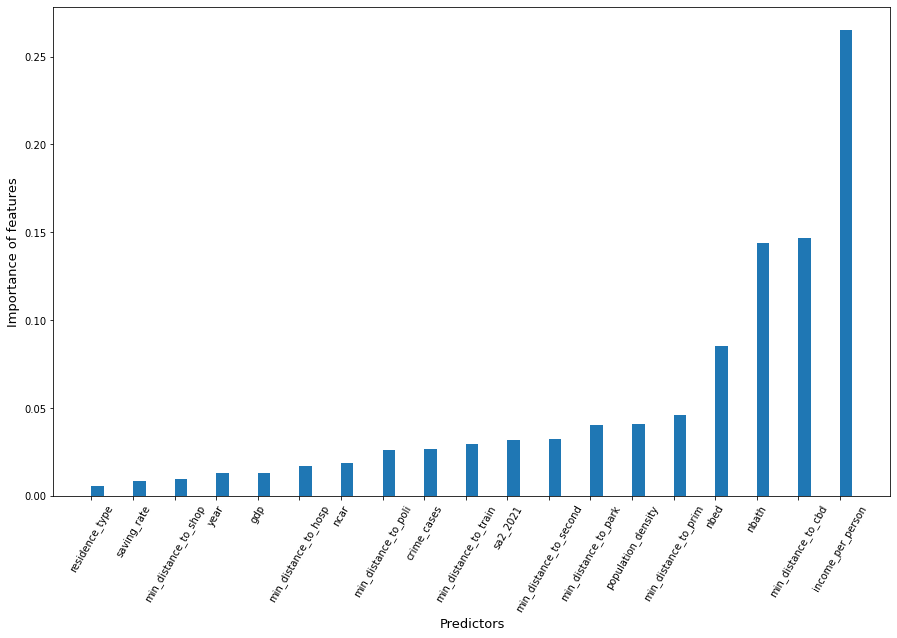

In [57]:
import matplotlib.pyplot as plt
dict = {}
for i in range(len(X.columns)):
    dict[X.columns[i]] = sel.feature_importances_[i]

print(dict)
sorted_dict = sorted(dict.items(), key=lambda x:x[1])
print(sorted_dict)

keys = []
vals = []
for i in sorted_dict:
    keys.append(i[0])
    vals.append(i[1])

print(keys, vals)


plt.figure(figsize=(15, 9))  # width:20, height:3

plt.bar(keys, vals, align='edge', width=0.3)
plt.xticks(rotation=60)
plt.ylabel("Importance of features", fontsize = 13)
plt.xlabel("Predictors", fontsize = 13)
plt.show()

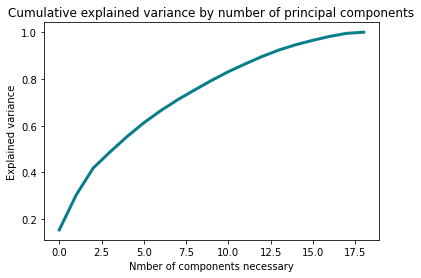

In [41]:
# Scrutinize the data with PCA: Test the attribute relevance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

In [59]:
# Check the accuracy before predicting with the trained random forest regressor
prediction = sel.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)

# Calculate the absolute errors
errors = abs(prediction - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

print(X_test)
print(list(zip(y_test, prediction)))

0.05529848981066735
0.23515630931503273
Mean Absolute Error: 0.14 degrees.
Accuracy: 97.68 %.
        year     sa2_2021  residence_type  nbed  nbath  ncar  \
120427  2022  207011522.0               1   3.0    1.0   1.0   
120428  2022  203021039.0               1   3.0    1.0   1.0   
120429  2022  208031189.0               1   3.0    2.0   2.0   
120430  2022  203031051.0               1   3.0    1.0   0.0   
120431  2022  201011001.0               0   2.0    1.0   1.0   
...      ...          ...             ...   ...    ...   ...   
172030  2022  205021086.0               1   3.0    1.0   1.0   
172031  2022  217041479.0               1   3.0    2.0   2.0   
172032  2022  208021177.0               1   2.0    2.0   1.0   
172033  2022  206041506.0               0   1.0    1.0   1.0   
172034  2022  206071139.0               0   1.0    1.0   1.0   

        min_distance_to_cbd  min_distance_to_park  min_distance_to_prim  \
120427              5.94339               0.46699             